In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from glob import glob
from astropy.io import fits
import astroalign

In [2]:
m27_path = '/home/aalvarez/Obs/M27'
output_path = os.path.join(m27_path, 'out')
os.makedirs(output_path, exist_ok=True)

In [3]:
bands = ['B', 'V', 'Ha']

## Utils

In [4]:
def trim_overscan(hdu):
    x_start = hdu.header['XORG_VIS']
    y_start = hdu.header['YORG_VIS']
    width = hdu.header['WID_VIS']
    height = hdu.header['HT_VIS']
    return hdu.data[y_start:y_start+height,x_start:x_start+width]

## Build master bias

In [5]:
def build_master_bias(input_path, output_file):
    if os.path.exists(output_file):
        return fits.open(output_file)[0].data
    frame_paths = glob(os.path.join(input_path, 'bias.*.*.Bias.fit'))
    print(f'Combining {len(frame_paths)} frames')
    frames = []
    for p in frame_paths:
        frame = fits.open(p)[0]
        assert(frame.header['EXPTIME'] == 0)
        frames.append(frame.data)
    data = np.median(frames, axis=0)
    fits.writeto(output_file, data, header=frame.header, overwrite=True)
    return data

In [6]:
master_bias = os.path.join(output_path, 'master_bias.fit')
master_bias_data = build_master_bias(m27_path, master_bias)

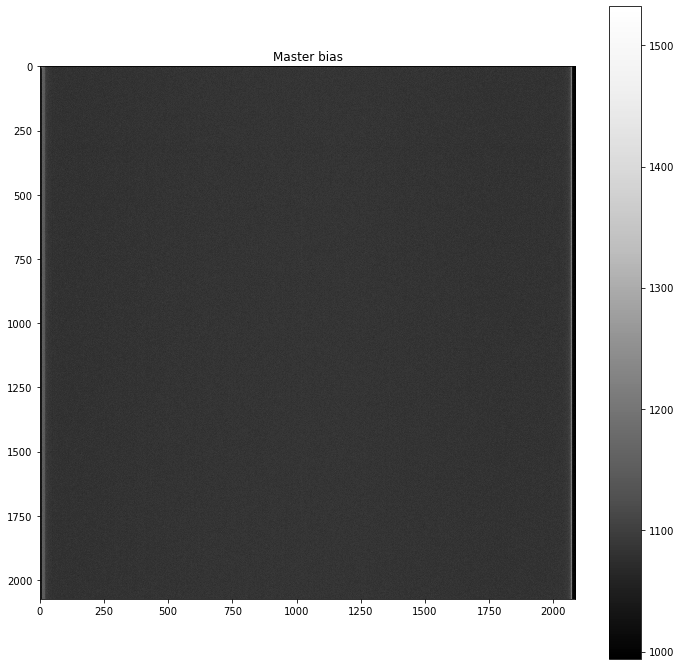

In [7]:
plt.figure(figsize=(12,12))
plt.imshow(master_bias_data, cmap=plt.get_cmap('Greys_r'))
plt.colorbar()
plt.title('Master bias')
plt.show()

## Build master dark

In [8]:
def build_master_dark(input_path, output_file, master_bias_path):
    if os.path.exists(output_file):
        return fits.open(output_file)[0].data
    master_bias = fits.open(master_bias_path)[0].data
    frame_paths = glob(os.path.join(input_path, 'dark.*.*.Dark.fit'))
    print(f'Combining {len(frame_paths)} frames')
    frames = []
    for p in frame_paths:
        frame = fits.open(p)[0]
        data = frame.data - master_bias
        frames.append(data)
    data = np.median(frames, axis=0)
    fits.writeto(output_file, data, header=frame.header, overwrite=True)
    return data

In [9]:
master_dark = os.path.join(output_path, 'master_dark.fit')
master_dark_data = build_master_dark(m27_path, master_dark, master_bias)

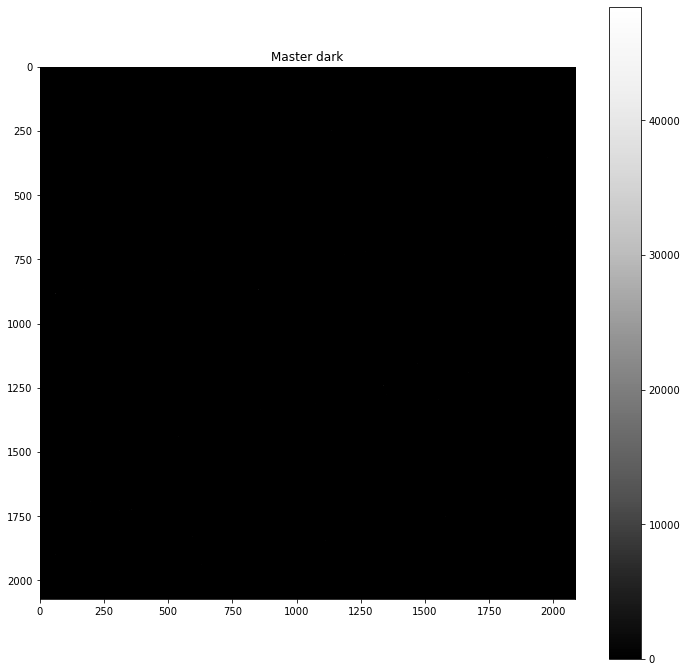

In [10]:
plt.figure(figsize=(12,12))
plt.imshow(master_dark_data, cmap=plt.get_cmap('Greys_r'))
plt.colorbar()
plt.title('Master dark')
plt.show()

## Build master flats

In [13]:
def build_master_flat(input_path, band, output_file, master_bias_path, master_dark_path):
    if os.path.exists(output_file):
        return fits.open(output_file)[0].data
    master_bias = fits.open(master_bias_path)[0]
    master_dark = fits.open(master_dark_path)[0]
    master_dark_exp = master_dark.header['EXPTIME']
    
    frame_paths = glob(os.path.join(input_path, 'Flat{band}.*.*.FlatField.fit'.format(band=band)))
    print(f'Combining {len(frame_paths)} frames for {band}')
    
    frames = []
    for p in frame_paths:
        frame = fits.open(p)[0]
        frame_exp = frame.header['EXPTIME']
        data = frame.data - master_bias.data - (master_dark.data * frame_exp / master_dark_exp)
        frames.append(data)
        
    data = np.median(frames, axis=0)
    data /= np.median(data)
    fits.writeto(output_file, data, header=frame.header, overwrite=True)
    return data

In [14]:
master_flat = dict()
master_flat_data = dict()
for band in bands:
    master_flat[band] = os.path.join(output_path, f'master_flat_{band}.fit')
    master_flat_data[band] = build_master_flat(m27_path, band, master_flat[band], master_bias, master_dark)

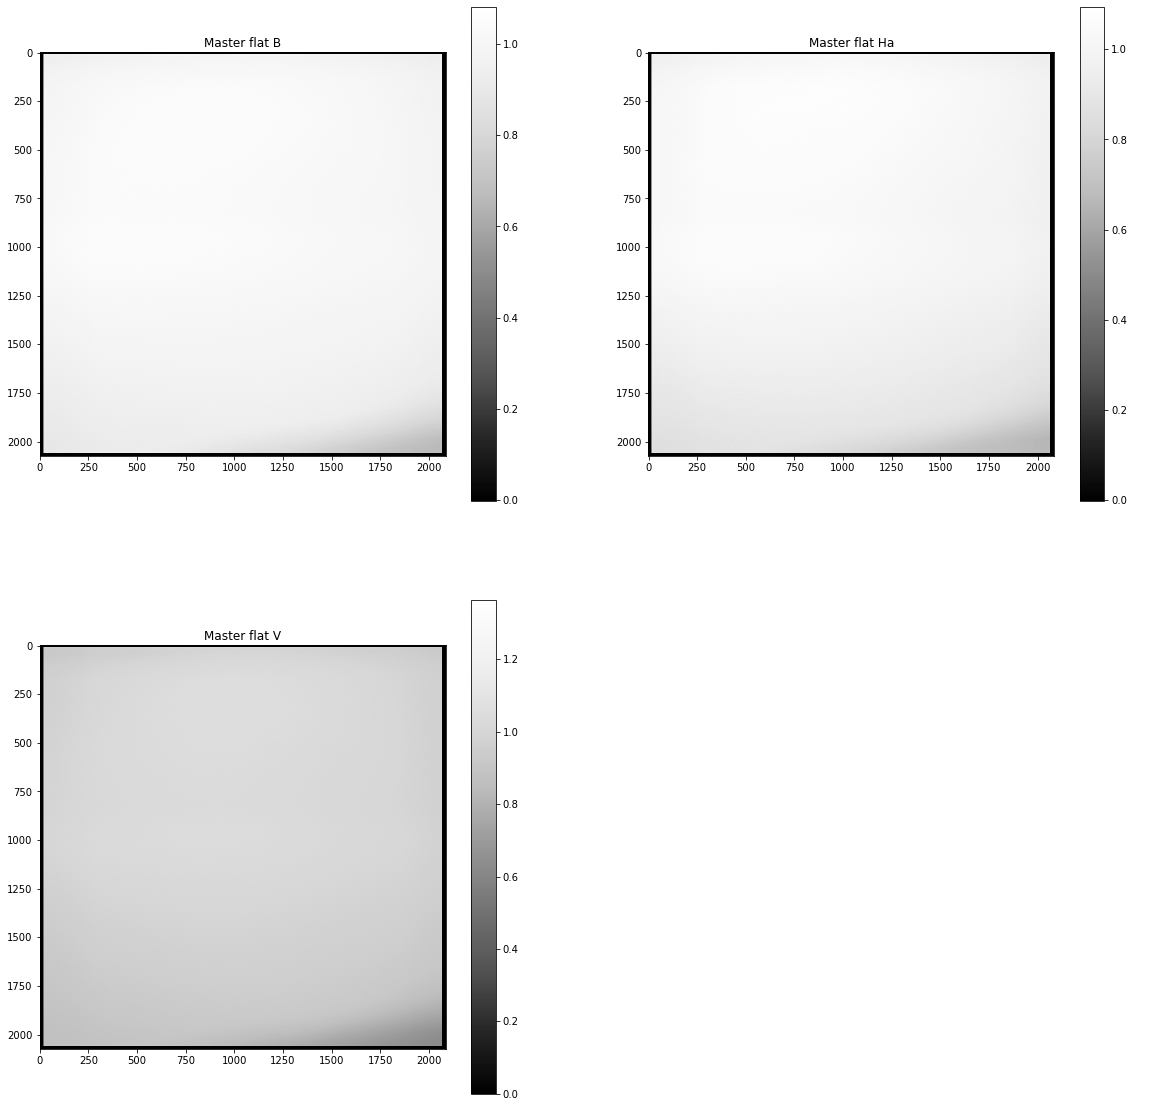

In [15]:
fig, axes = plt.subplots(2 , 2,figsize=(20,20))
for i, band in enumerate(bands):
    x = i % 2
    y = i // 2
    axes[x,y].set_title(f'Master flat {band}')
    im = axes[x,y].imshow(master_flat_data[band], cmap=plt.get_cmap('Greys_r'))
    plt.colorbar(im, ax=axes[x,y])

axes[1,1].axis('off')
plt.show()

## Build stacked frames

In [16]:
def detrend(input_path, band, output_path, master_bias_path, master_dark_path, master_flat_path):
    master_bias = fits.open(master_bias_path)[0]
    master_dark = fits.open(master_dark_path)[0]
    master_flat = fits.open(master_flat_path)[0]
    
    master_dark_exp = master_dark.header['EXPTIME']
    
    frame_paths = glob(os.path.join(input_path, 'm27{band}*.fit'.format(band=band)))
    for p in frame_paths:
        print(f'Detrending {p}')
        frame = fits.open(p)[0]
        frame_exp = frame.header['EXPTIME']
        frame.data = frame.data - master_bias.data - master_dark.data * (frame_exp / master_dark_exp)
        frame.data /= master_flat.data
        frame.data = trim_overscan(frame)
        output = os.path.join(output_path, os.path.basename(p))
        fits.writeto(output, frame.data, header=frame.header, overwrite=True)

In [17]:
for band in bands:
    detrend(m27_path, band, output_path, master_bias, master_dark, master_flat[band])

Detrending /home/aalvarez/Obs/M27/m27B30.00011401.GSC 2141_287.fit


/home/aalvarez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/aalvarez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Detrending /home/aalvarez/Obs/M27/m27B30.00011402.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011408.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011403.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011394.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011392.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011391.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011404.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011398.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011396.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011399.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011400.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011390.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011389.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011405.GSC 2141_287.fit
Detrending /home/aalvarez/Obs/M27/m27B30.00011393.GSC 2141_287

In [52]:
def stack(output_path, band, reference, method='median'):
    frame_paths = glob(os.path.join(output_path, 'm27{band}*.fit'.format(band=band)))
    stacked_output = os.path.join(output_path, f'stacked_{band}.fit')
    if os.path.exists(stacked_output):
        return fits.open(stacked_output)[0].data
    
    all_frames = []
    for p in frame_paths:
        print(f'Aligning {p}')
        frame = fits.open(p)[0]
        frame.data /= frame.header['EXPTIME']
        aligned = astroalign.register(frame.data, reference)
        all_frames.append(aligned)
    
    print(f'Stacking {band}')
    if method == 'median':
        data = np.ma.median(all_frames, axis=0)
    elif method == 'mean':
        data = np.ma.mean(all_frames, axis=0)
    else:
        raise ValueError('Unknown method')
    fits.writeto(stacked_output, data.filled(0), overwrite=True)
    return data

In [53]:
stacked = dict()
reference = fits.open(
    glob(os.path.join(output_path, 'm27*'))[0]
)[0].data

for band in bands:
    stacked[band] = stack(output_path, band, reference)

Aligning /home/aalvarez/Obs/M27/out/m27B30.00011401.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011402.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011408.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011403.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011394.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011392.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011391.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011404.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011398.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011396.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011399.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011400.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011390.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/out/m27B30.00011389.GSC 2141_287.fit
Aligning /home/aalvarez/Obs/M27/ou

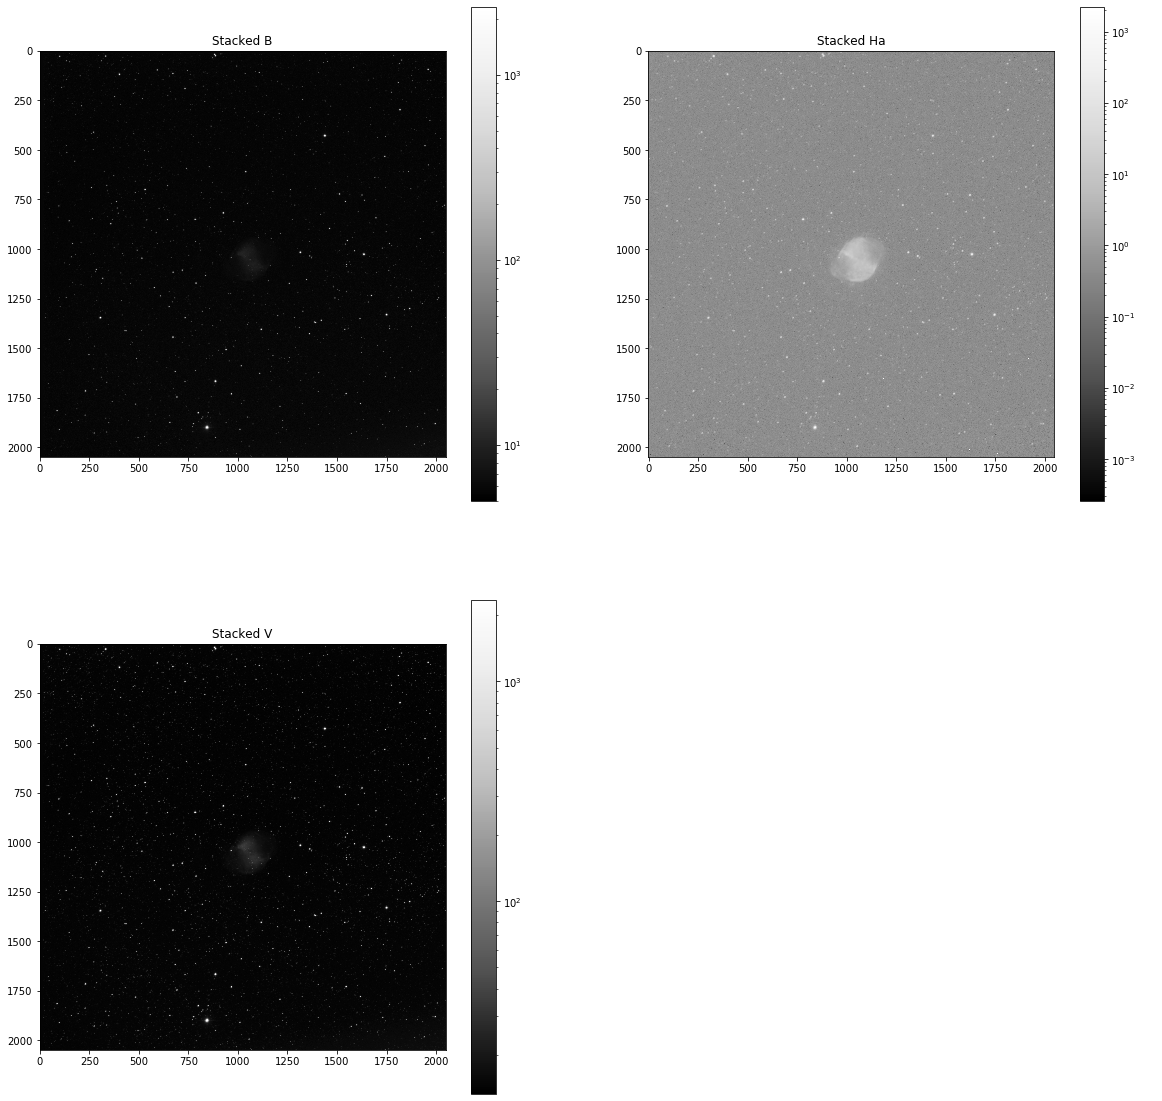

In [55]:
fig, axes = plt.subplots(2 , 2,figsize=(20,20))
for i, band in enumerate(bands):
    x = i % 2
    y = i // 2
    axes[x,y].set_title(f'Stacked {band}')
    im = axes[x,y].imshow(stacked[band], cmap=plt.get_cmap('Greys_r'), norm=colors.LogNorm())
    plt.colorbar(im, ax=axes[x,y])

axes[1,1].axis('off')
plt.show()